# FIT5226 Project: Multi-Agent Q-Learning Solution
**Options Purchased:** Opposite‑type neighbor sensor (3), Central clock (1), Off‑the‑job training (2)

**Acknowledgment:** Parts of this code were generated with ChatGPT (OpenAI) and have been manually reviewed and adapted.

**Infinite-horizon Note:** This implementation approximates the infinite shuttle task using repeated 20-step sub-episodes, preserving ongoing pickup/delivery cycles without terminal states.

In [2]:
# 1. Imports & Hyperparameters
import numpy as np
import random
import time
import pickle
import matplotlib.pyplot as plt

GRID_SIZE = 5
NUM_AGENTS = 4
# Budgets
STEP_BUDGET = 1_500_000
COLLISION_BUDGET = 4000
WALLTIME_BUDGET = 600  # seconds
# Learning hyperparams
EPSILON = 0.1
ALPHA = 0.1
GAMMA = 0.99

In [3]:
# 2. Environment & Agent Definition
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # N, S, W, E

class Agent:
    def __init__(self, idx, shared_q):
        self.idx = idx
        self.q_table = shared_q
        self.epsilon = EPSILON
        self.alpha = ALPHA
        self.gamma = GAMMA
        self.rewards = []  # per-step rewards

    def reset(self, A_loc, B_loc, start_at_A):
        # Off-the-job: fixed start at A or B
        self.pos = A_loc if start_at_A else B_loc
        self.carrying = start_at_A

    def get_neighbors_state(self, grid, agents):
        bits = ''
        for dx, dy in actions:
            nx, ny = self.pos[0] + dx, self.pos[1] + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and grid[nx][ny] != -1:
                other = agents[grid[nx][ny]]
                if other.carrying != self.carrying:
                    bits += '1'
                    continue
            bits += '0'
        return bits

    def get_state(self, A_loc, B_loc, grid, agents):
        # State includes position, carrying, neighbor mask, and A/B coords
        neighbors = self.get_neighbors_state(grid, agents)
        return (self.pos[0], self.pos[1], int(self.carrying), neighbors,
                A_loc[0], A_loc[1], B_loc[0], B_loc[1])

    def choose_action(self, state, eval_mode=False):
        if (not eval_mode and random.random() < self.epsilon) or state not in self.q_table:
            return random.randint(0, 3)
        return int(np.argmax(self.q_table[state]))

    def update_q(self, s, a, r, sp):
        if s not in self.q_table:
            self.q_table[s] = [0.0] * 4
        if sp not in self.q_table:
            self.q_table[sp] = [0.0] * 4
        max_next = max(self.q_table[sp])
        self.q_table[s][a] += self.alpha * (r + self.gamma * max_next - self.q_table[s][a])


In [4]:
# 3. Helper: detect head-on collisions (including swaps), ignoring A and B
def detect_head_on(proposed, current, carrying, A_loc, B_loc):
    events = set()
    n = len(proposed)
    for i in range(n):
        for j in range(i+1, n):
            # same target cell
            if proposed[i] == proposed[j] and carrying[i] != carrying[j]:
                if proposed[i] not in {A_loc, B_loc}:
                    events.add((i,j))
            # swap positions
            if proposed[i] == current[j] and proposed[j] == current[i] and carrying[i] != carrying[j]:
                if proposed[i] not in {A_loc, B_loc}:
                    events.add((i,j))
    return events

In [15]:
# 4. Training Loop
shared_q = {}
agents = [Agent(i, shared_q) for i in range(NUM_AGENTS)]

metrics = {'episode': [], 'collisions': [], 'steps': [], 'episode_reward': []}
total_steps = 0
collision_count = 0
start_time = time.time()
episode = 0

while total_steps < STEP_BUDGET and collision_count < COLLISION_BUDGET and (time.time() - start_time) < WALLTIME_BUDGET:
    # Randomize A and B each episode
    cells = [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]
    A_loc, B_loc = random.sample(cells, 2)

    # Off-the-job: half agents start at A, half at B
    starts = [i < (NUM_AGENTS // 2) for i in range(NUM_AGENTS)]

    # Initialize grid and agents
    grid = [[-1]*GRID_SIZE for _ in range(GRID_SIZE)]
    for i, ag in enumerate(agents):
        ag.reset(A_loc, B_loc, starts[i])
        grid[ag.pos[0]][ag.pos[1]] = i
        ag.rewards.clear()

    # Sub-episode of 20 steps
    ep_reward = 0
    for _ in range(20):
        current_positions = [ag.pos for ag in agents]
        carrying_states = [ag.carrying for ag in agents]
        # Propose moves
        proposals = []
        states_actions = []
        for ag in agents:
            st = ag.get_state(A_loc, B_loc, grid, agents)
            a = ag.choose_action(st)
            proposals.append((min(max(ag.pos[0]+actions[a][0],0),GRID_SIZE-1),
                              min(max(ag.pos[1]+actions[a][1],0),GRID_SIZE-1)))
            states_actions.append((st, a))
        # Detect head-on collisions
        events = detect_head_on(proposals, current_positions, carrying_states, A_loc, B_loc)
        # Execute moves and update Q
        new_grid = [[-1]*GRID_SIZE for _ in range(GRID_SIZE)]
        for pair in events:
            collision_count += 1
        total_steps += NUM_AGENTS
        for i, ag in enumerate(agents):
            prev_st, act = states_actions[i]
            ag.pos = proposals[i]
            # pickup/drop reward
            r = 0
            if ag.pos == A_loc and not ag.carrying:
                ag.carrying = True; r += 1
            elif ag.pos == B_loc and ag.carrying:
                ag.carrying = False; r += 1
            # collision penalty
            for pair in events:
                if i in pair:
                    r -= 10
            ep_reward += r
            # Q update
            next_st = ag.get_state(A_loc, B_loc, new_grid, agents)
            ag.update_q(prev_st, act, r, next_st)
            # update grid
            new_grid[ag.pos[0]][ag.pos[1]] = i
        grid = new_grid
    # Record metrics
    episode += 1
    metrics['episode'].append(episode)
    metrics['collisions'].append(collision_count)
    metrics['steps'].append(total_steps)
    metrics['episode_reward'].append(ep_reward / (NUM_AGENTS * 20))

print(f"Training done: episodes={episode}, steps={total_steps}, collisions={collision_count}, time={time.time()-start_time:.1f}s")

# Save Q-table for re-testing
with open('q_table.pkl', 'wb') as f:
    pickle.dump(shared_q, f)

Training done: episodes=2747, steps=219760, collisions=4001, time=2.7s


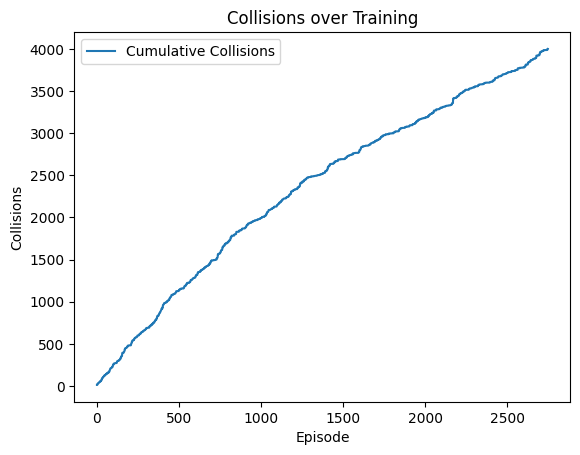

In [16]:
# 5. Collision Budget over Episodes
plt.figure()
plt.plot(metrics['episode'], metrics['collisions'], label='Cumulative Collisions')
plt.xlabel('Episode')
plt.ylabel('Collisions')
plt.title('Collisions over Training')
plt.legend()
plt.show()

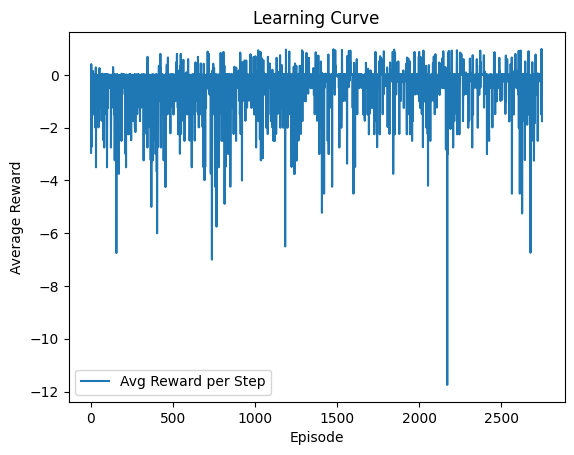

In [17]:
# 6. Learning Curve (Average Reward per Step)
plt.figure()
plt.plot(metrics['episode'], metrics['episode_reward'], label='Avg Reward per Step')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [18]:
# 7. Final Performance Evaluation (25-step criterion)
def evaluate_final(agents, trials=100, max_steps=25):
    succ = 0
    for _ in range(trials):
        cells = [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]
        A_loc, B_loc = random.sample(cells, 2)
        grid = [[-1]*GRID_SIZE for _ in range(GRID_SIZE)]
        for ag in agents:
            ag.reset(A_loc, B_loc, False)
            grid[ag.pos[0]][ag.pos[1]] = ag.idx
        delivered = [False]*NUM_AGENTS
        collision = False
        for _ in range(max_steps):
            curr = [ag.pos for ag in agents]
            carry = [ag.carrying for ag in agents]
            props = []
            for ag in agents:
                st = ag.get_state(A_loc, B_loc, grid, agents)
                a = ag.choose_action(st, eval_mode=True)
                dx, dy = actions[a]
                props.append((min(max(ag.pos[0]+dx,0),GRID_SIZE-1), min(max(ag.pos[1]+dy,0),GRID_SIZE-1)))
            events = detect_head_on(props, curr, carry, A_loc, B_loc)
            if events:
                collision = True
                break
            grid = [[-1]*GRID_SIZE for _ in range(GRID_SIZE)]
            for i, ag in enumerate(agents):
                ag.pos = props[i]
                if ag.pos == A_loc and not ag.carrying:
                    ag.carrying = True
                elif ag.pos == B_loc and ag.carrying:
                    ag.carrying = False
                    delivered[i] = True
                grid[ag.pos[0]][ag.pos[1]] = i
            if any(delivered):
                break
        if any(delivered) and not collision:
            succ += 1
    rate = succ / trials * 100
    print(f"Final success rate (≤{max_steps} steps): {rate:.1f}%")
    return rate

final_rate = evaluate_final(agents)

Final success rate (≤25 steps): 6.0%


In [39]:
# 8. Performance Points and Mark Scaling
def evaluate_points(agents, training_collisions, trials=100, max_steps=20):
    succ = 0
    for _ in range(trials):
        cells = [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]
        A_loc, B_loc = random.sample(cells, 2)
        grid = [[-1]*GRID_SIZE for _ in range(GRID_SIZE)]
        for ag in agents:
            ag.reset(A_loc, B_loc, False)
            grid[ag.pos[0]][ag.pos[1]] = ag.idx
        delivered = [False]*NUM_AGENTS
        collision = False
        for _ in range(max_steps):
            curr = [ag.pos for ag in agents]
            carry = [ag.carrying for ag in agents]
            props = []
            for ag in agents:
                st = ag.get_state(A_loc, B_loc, grid, agents)
                a = ag.choose_action(st, eval_mode=True)
                dx, dy = actions[a]
                props.append((min(max(ag.pos[0]+dx,0),GRID_SIZE-1), min(max(ag.pos[1]+dy,0),GRID_SIZE-1)))
            events = detect_head_on(props, curr, carry, A_loc, B_loc)
            if events:
                collision = True
                break
            grid = [[-1]*GRID_SIZE for _ in range(GRID_SIZE)]
            for i, ag in enumerate(agents):
                ag.pos = props[i]
                if ag.pos == A_loc and not ag.carrying:
                    ag.carrying = True
                elif ag.pos == B_loc and ag.carrying:
                    ag.carrying = False
                    delivered[i] = True
                grid[ag.pos[0]][ag.pos[1]] = i
            if any(delivered):
                break
        if any(delivered) and not collision:
            succ += 1
    rate = succ / trials * 100
    points = 0
    if rate > 95 and training_collisions < 500:
        points = 2
    elif rate > 85 and training_collisions < 1000:
        points = 1
    C = 3 + 1 + 2  # total purchase cost
    B = points
    alpha = 1 - (33/200) * max(0, C - B)
    print(f"Performance (<{max_steps} steps): {rate:.1f}%")
    print(f"Training collisions: {training_collisions}")
    print(f"Performance points B: {B}")
    print(f"Mark scaling factor α: {alpha:.3f}")
    return rate, points, alpha

perf_rate, perf_points, mark_alpha = evaluate_points(agents, collision_count)

Performance (<20 steps): 5.0%
Training collisions: 4001
Performance points B: 0
Mark scaling factor α: 0.010
